In [16]:
#======Core============
import pandas as pd
import numpy as np
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
#======PyForecast======
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
#======UEXP============
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *
#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta
#=========================

# Get Data and format into long form (WRONG, NBEATS CANT WORK WITH THIS)

In [17]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2021-12-30"
end_date = "2021-12-31"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-29.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-30.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-31.csv


/Users/dan/Desktop/projects/uexp/ue/uexp/dataprocessing/processor_binance.py:225: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  security = security.append(dailyfinal)
/Users/dan/Desktop/projects/uexp/ue/uexp/dataprocessing/processor_binance.py:225: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  security = security.append(dailyfinal)
/Users/dan/Desktop/projects/uexp/ue/uexp/dataprocessing/processor_binance.py:229: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(security)


In [19]:
def py_fc_prep_data(start_date, end_date, interval='1s', tickers=["BTCUSDT"], version="full"):
    """
    using the processor gets data and saves to cache/{fname}.csv, used for python-forecasting models
    
    args:
        - start_date: str
        - end_date: str
    
    returns:
        - dict: {
        time_idx:
        target
        categorical_encoders
        group_ids:
        time_varying_unknown_reals
        }
    """
    data_path = "{start}-{end}-of-{tics}-{version}-{interval}.csv".format(
        start=start_date,
        end=end_date,
        tics="_".join(tickers),
        version=version,
        interval=interval,
    )
    #check if saved
    if os.path.exists(os.path.join("cache",data_path)):
        return pd.read_csv(data_path)
    
    p = BinanceProcessor("binance")
    df = p.download_data(tickers, start_date, end_date, interval)
    df.columns = ["Open","High","Low","Close","Volume", "Tic"]
    
    if version == "full":
        # see doc for details of full
        # https://docs.google.com/document/d/1oo-EgHCVQyvjKiC8cAocfwpZzRHSXDr3YCZJ-agoFv4/edit?usp=sharing
        
        # Relative Strength Index (RSI)
        df["momentum_rsi"] = RSIIndicator(
            close=df["Close"], window=14, fillna=True
        ).rsi()/100 #scale 0-1
        
        # Stoch RSIs (StochRSI)
        indicator_srsi = StochRSIIndicator(
            close=df["Close"], window=14, smooth1=3, smooth2=3, fillna=True
        )
        df["momentum_stoch_rsi"] = indicator_srsi.stochrsi()
        df["momentum_stoch_rsi_k"] = indicator_srsi.stochrsi_k()
        df["momentum_stoch_rsi_d"] = indicator_srsi.stochrsi_d()
        
        # TSI Indicator
        df["momentum_tsi"] = TSIIndicator(
            close=df["Close"], window_slow=25, window_fast=13, fillna=True
        ).tsi()/100 #scale 0-1

        # Chaikin Money Flow
        df["volume_cmf"] = ChaikinMoneyFlowIndicator(
            high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
        ).chaikin_money_flow()

        # Money Flow Index
        df["volume_mfi"] = MFIIndicator(
                    high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
                ).money_flow_index()/100 #norm to 0-1

        # Force Index
        df["volume_fi"] = ForceIndexIndicator(
            close=df["Close"], volume=df["Volume"], window=13, fillna=True
        ).force_index()

        # Volume Weighted Average Price
        df["volume_vwap"] = VolumeWeightedAveragePrice(
            high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True,
            window=14,
        ).volume_weighted_average_price()
        
        # MACD
        indicator_macd = MACD(
            close=df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True
        )
        df["trend_macd"] = indicator_macd.macd()
        df["trend_macd_signal"] = indicator_macd.macd_signal()
        df["trend_macd_diff"] = indicator_macd.macd_diff()

        # SMAs
        df["trend_sma_fast"] = SMAIndicator(
            close=df["Close"], window=12, fillna=True
        ).sma_indicator()
        df["trend_sma_slow"] = SMAIndicator(
            close=df["Close"], window=26, fillna=True
        ).sma_indicator()

        # EMAs
        df["trend_ema_fast"] = EMAIndicator(
            close=df["Close"], window=12, fillna=True
        ).ema_indicator()
        df["trend_ema_slow"] = EMAIndicator(
            close=df["Close"], window=26, fillna=True
        ).ema_indicator()
        
        def stationize(series):
            return np.log(series / series.shift(1))
        
        #Turn price into logrets 
        df['log_ret'] = stationize(df['Close'])
        df['log_volume_vwap_ret'] = stationize(df['volume_vwap'])
        df['log_trend_sma_slow_ret'] = stationize(df['trend_sma_slow'])
        df['log_trend_sma_fast_ret'] = stationize(df['trend_sma_fast'])
        df['log_trend_ema_slow_ret'] = stationize(df['trend_ema_slow'])
        df['log_trend_ema_fast_ret'] = stationize(df['trend_ema_fast'])
        
        #Build time_idx, series for all series
        df.reset_index(inplace=True)
        df.rename(columns={'index':'time'}, inplace=True)
        df['time_idx'] = df.index
        
        #df['series'] = np.NaN #... is this the best way to handle this...?
        
        #Save to csv
        #df.to_csv(os.path.join("cache",data_path))
        return df
    else:
        #default to OHLCV
        pass

In [20]:
df = py_fc_prep_data("2021-12-30", "2021-12-31")

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-29.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-30.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-31.csv


/Users/dan/Desktop/projects/uexp/ue/uexp/dataprocessing/processor_binance.py:225: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  security = security.append(dailyfinal)
/Users/dan/Desktop/projects/uexp/ue/uexp/dataprocessing/processor_binance.py:225: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  security = security.append(dailyfinal)
/Users/dan/Desktop/projects/uexp/ue/uexp/dataprocessing/processor_binance.py:229: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(security)


In [21]:
df.head()

,time,Open,High,Low,Close,Volume,Tic,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,...,trend_sma_slow,trend_ema_fast,trend_ema_slow,log_ret,log_volume_vwap_ret,log_trend_sma_slow_ret,log_trend_sma_fast_ret,log_trend_ema_slow_ret,log_trend_ema_fast_ret,time_idx
0,2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143,BTCUSDT,1.0,0.0,0.0,...,46467.730000,46467.730000,46467.730000,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520,BTCUSDT,0.0,0.0,0.0,...,46466.030000,46467.206923,46467.478148,-7.317173e-05,-2.465492e-05,-0.000037,-0.000037,-0.000005,-0.000011,1
2,2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925,BTCUSDT,0.0,0.0,0.0,...,46462.696667,46465.487396,46466.630137,-1.786476e-04,-2.780899e-05,-0.000072,-0.000072,-0.000018,-0.000037,2
3,2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054,BTCUSDT,0.0,0.0,0.0,...,46461.030000,46464.032412,46465.844942,0.000000e+00,-8.452871e-07,-0.000036,-0.000036,-0.000017,-0.000031,3
4,2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262,BTCUSDT,0.0,0.0,0.0,...,46460.028000,46462.799734,46465.117168,-2.152573e-07,-1.284331e-05,-0.000022,-0.000022,-0.000016,-0.000027,4


In [22]:
df.columns

Index(['time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Tic', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'volume_cmf', 'volume_mfi', 'volume_fi', 'volume_vwap',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'log_ret',
       'log_volume_vwap_ret', 'log_trend_sma_slow_ret',
       'log_trend_sma_fast_ret', 'log_trend_ema_slow_ret',
       'log_trend_ema_fast_ret', 'time_idx'],
      dtype='object')

In [23]:
non_indicators = ["time_idx","time","Tic"]
indicators = [A for A in df.columns if A not in non_indicators]
indicators

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'momentum_rsi',
 'momentum_stoch_rsi',
 'momentum_stoch_rsi_k',
 'momentum_stoch_rsi_d',
 'momentum_tsi',
 'volume_cmf',
 'volume_mfi',
 'volume_fi',
 'volume_vwap',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'log_ret',
 'log_volume_vwap_ret',
 'log_trend_sma_slow_ret',
 'log_trend_sma_fast_ret',
 'log_trend_ema_slow_ret',
 'log_trend_ema_fast_ret']

# TSDS

In [25]:
# define dataset: lookback 30 intervals, predict 10 into future
history_window = 30
future_window = 10
training_cutoff = data["time_idx"].max() - future_window
training_cutoff

389

In [26]:
# drop beginning NAs
df.dropna(inplace=True)

In [27]:
assert df.isnull().sum().sum() == 0

In [28]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Close",
    #categorical_encoders={"series": NaNLabelEncoder().fit(df.series)},
    group_ids=indicators,
    # only unknown variable is "close" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=['Close'],
    max_encoder_length=history_window,
    max_prediction_length=future_window,
    allow_missing_timesteps=True,
)

/Users/dan/miniforge3/lib/python3.9/site-packages/pytorch_forecasting/data/timeseries.py:1238: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 389 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Open': 46300.0, '__group_id__High': 46300.0, '__group_id__Low': 46299.99, '__group_id__Close': 46300.0, '__group_id__Volume': 0.43244000000000005, '__group_id__momentum_rsi': 0.09994748688977992, '__group_id__momentum_stoch_rsi': 0.0, '__group_id__momentum_stoch_rsi_k': 0.0015019997350556294, '__group_id__momentum_stoch_rsi_d': 0.020434391832070607, '__group_id__momentum_tsi': -0.6980230453767006, '__group_id__volume_cmf': -0.6748525542555924, '__group_id__volume_mfi': 0.016948297440821988, '__group_id__volume_fi': -4.760428240949781, '__group_id__volume_vwap': 46329.268603603035, '__group_id__trend_macd': -23.03

AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [3]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [94]:
dff = pd.melt(df, id_vars=["time_idx", "series"], value_vars=indicators)
dff.head()

,time_idx,series,variable,value
0,0,NaN,Open,46464.66
1,1,NaN,Open,46467.73
2,2,NaN,Open,46461.29
3,3,NaN,Open,46456.02
4,4,NaN,Open,46456.02


In [95]:
for i, ind in enumerate(indicators):
    dff.loc[dff['variable'] == ind, 'series'] = i

In [96]:
dff.tail()

,time_idx,series,variable,value
4665595,172795,26.0,log_trend_ema_fast_ret,-0.000011
4665596,172796,26.0,log_trend_ema_fast_ret,-0.000009
4665597,172797,26.0,log_trend_ema_fast_ret,-0.000064
4665598,172798,26.0,log_trend_ema_fast_ret,-0.000054
4665599,172799,26.0,log_trend_ema_fast_ret,0.000010


In [97]:
dff['series'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26.])

In [98]:
dff.isnull().sum()

time_idx    0
series      0
variable    0
value       6
dtype: int64

In [99]:
df = pd.read_csv('always.csv')

In [100]:
df.columns = ['time', 'close', 'log_ret']
df['time_idx'] = df.index
df['series'] = 0
df['time'] = pd.to_datetime(df['time'])

In [101]:
df = df.dropna()
df.head()

,time,close,log_ret,time_idx,series
1,2022-02-03 00:00:01,36902.81,-0.000004,1,0
2,2022-02-03 00:00:02,36899.19,-0.000098,2,0
3,2022-02-03 00:00:03,36900.54,0.000037,3,0
4,2022-02-03 00:00:04,36895.62,-0.000133,4,0
5,2022-02-03 00:00:05,36900.26,0.000126,5,0


In [102]:
df.tail()

,time,close,log_ret,time_idx,series
172795,2022-02-04 23:59:55,41545.77,-0.000261,172795,0
172796,2022-02-04 23:59:56,41549.21,0.000083,172796,0
172797,2022-02-04 23:59:57,41545.98,-0.000078,172797,0
172798,2022-02-04 23:59:58,41552.02,0.000145,172798,0
172799,2022-02-04 23:59:59,41574.25,0.000535,172799,0


In [5]:
df.dtypes

time        datetime64[ns]
close              float64
log_ret            float64
time_idx             int64
series               int64
dtype: object

## TSDS

In [14]:
# define dataset: lookback 30 intervals, predict 10 into future
history_window = 30
future_window = 10
training_cutoff = df.index[-1000]
training_cutoff

171800

In [15]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="close",
    categorical_encoders={"series": NaNLabelEncoder().fit(df.series)},
    group_ids=["series"],
    # only unknown variable is "close" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["close"],
    max_encoder_length=history_window,
    max_prediction_length=future_window,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## baseline

In [125]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(9.8925e-05)

# NBEATS Model

In [126]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [133]:
net.summarize("full")

/var/folders/nw/q8c9lcfd38qg_8hw2py9hw840000gn/T/ipykernel_49948/4102843741.py:1: LightningDeprecationWarning: The `LightningModule.summarize` method is deprecated in v1.5 and will be removed in v1.7. Use `pytorch_lightning.utilities.model_summary.summarize` instead.
  net.summarize("full")
/Users/dan/miniforge3/lib/python3.9/site-packages/pytorch_lightning/utilities/model_summary.py:471: LightningDeprecationWarning: Argument `mode` in `LightningModule.summarize` is deprecated in v1.4 and will be removed in v1.6. Use `max_depth=-1` to replicate `mode=full` behavior.
  rank_zero_deprecation(


   | Name                    | Type                | Params
-----------------------------------------------------------------
0  | loss                    | MASE                | 0     
1  | logging_metrics         | ModuleList          | 0     
2  | logging_metrics.0       | SMAPE               | 0     
3  | logging_metrics.1       | MAE                 | 0     
4  | logging_metrics.2       | RMSE                | 0     
5  | logging_metrics.3       | MAPE                | 0     
6  | logging_metrics.4       | MASE                | 0     
7  | net_blocks              | ModuleList          | 1.6 M 
8  | net_blocks.0            | NBEATSTrendBlock    | 3.2 K 
9  | net_blocks.0.fc         | Sequential          | 3.1 K 
10 | net_blocks.0.fc.0       | Linear              | 992   
11 | net_blocks.0.fc.1       | ReLU                | 0     
12 | net_blocks.0.fc.2       | Sequential          | 1.1 K 
13 | net_blocks.0.fc.2.0     | Dropout             | 0     
14 | net_blocks.0.fc.2.1     | Lin

/Users/dan/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1079: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/Users/dan/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dan/miniforge3/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Global seed set to 42
/Users/dan/m

suggested learning rate: 0.017782794100389233


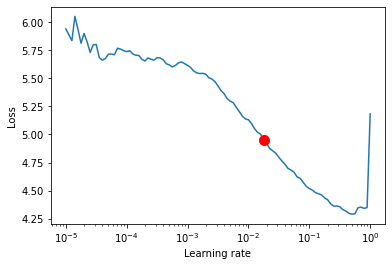

/var/folders/nw/q8c9lcfd38qg_8hw2py9hw840000gn/T/ipykernel_49948/3011316979.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [127]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [128]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/dan/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.594     Total estimated model params size (MB)


Global seed set to 42
/Users/dan/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dan/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|█| 31/31 [00:01<00:00, 17.03it/s, loss=4.39, v_num=1, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 31/31 [00:01<00:00, 16.07it/s, loss=4.39, v_num=1, train_loss_s
Epoch 1:  97%|▉| 30/31 [00:01<00:00, 16.51it/s, loss=3.58, v_num=1, train_loss_s
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 31/31 [00:01<00:00, 16.13it/s, loss=3.58, v_num=1, train_loss_s
Epoch 2:  97%|▉| 30/31 [00:01<00:00, 16.35it/s, loss=3.38, v_num=1, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 31/31 [00:02<00:00, 15.05it/s, loss=3.38, v_num=1, train_loss_s
Epoch 3:  97%|▉| 30/31 [00:01<00:00, 16.27it/s, loss=3.22, v_num=1, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 3: 100%|█| 31/31 [00:01<00:00, 15.86it/s, loss=3.22, v_num=1

# Evaluate Results

In [129]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [130]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(4.5043)

In [131]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

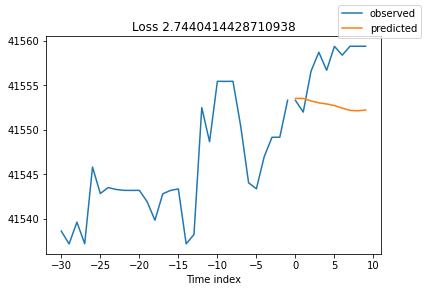

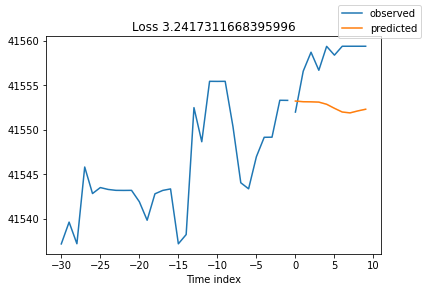

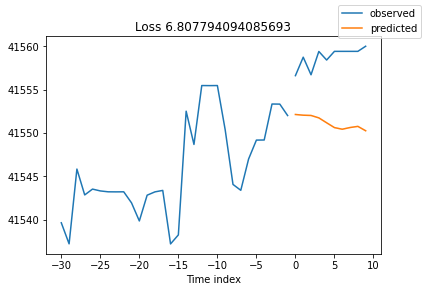

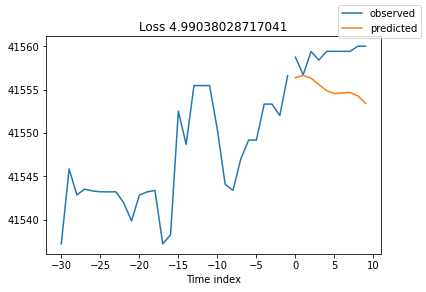

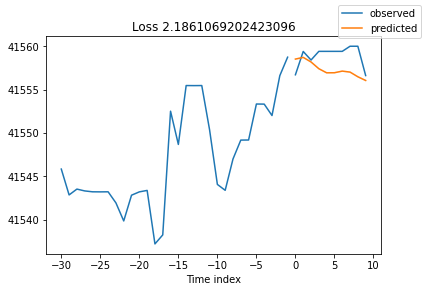

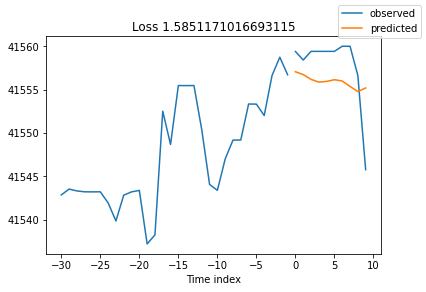

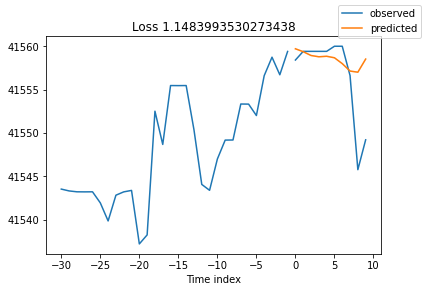

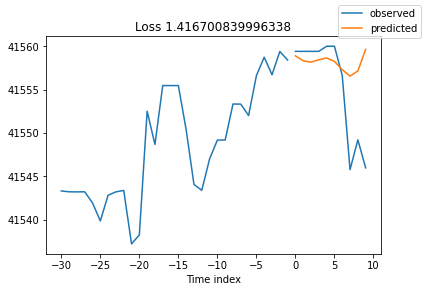

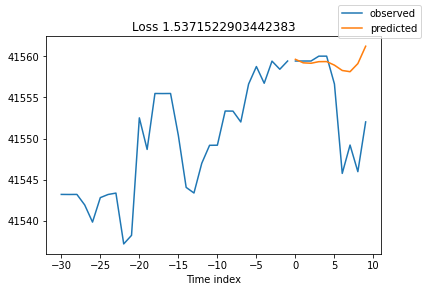

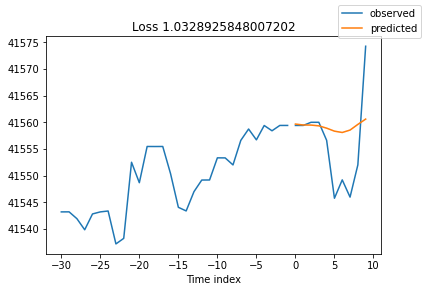

In [132]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

# Default example data

In [103]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [105]:
data

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05
...,...,...,...,...,...
39995,99,395,-5.587069,2,2021-01-30
39996,99,396,-4.986342,2,2021-01-31
39997,99,397,-5.630228,2,2021-02-01
39998,99,398,-5.745145,2,2021-02-02


In [104]:
data.series.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])